## NN Adv Assignment

- 제출자: 20기 황태연
- 제출 일자: 2023.08.29. (화)

- 참고: 본인의 Jupyter와 Colab은 모두 들여쓰기 4칸으로 설정되어 있습니다. 따라서 들여쓰기를 2칸에서 4칸으로 모두 수정하였습니다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train['label'].nunique()

10

In [6]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

- 훈련 데이터 셋의 이미지와 라벨을 20개 출력합니다.

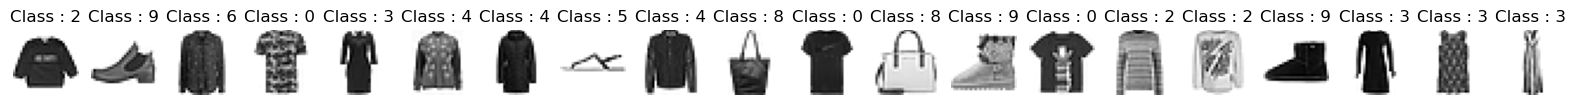

In [8]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
    plt.subplot(1, 20, idx + 1)
    plt.axis('off')
    plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
    plt.title(f'Class : {y[idx]}')

In [9]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

- 테스트 데이터 셋의 이미지를 20개 출력합니다.

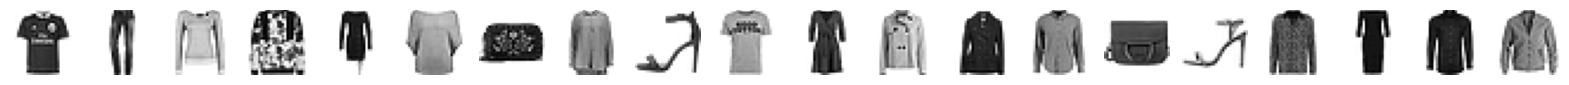

In [10]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
    plt.subplot(1, 20, idx + 1)
    plt.axis('off')
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

- 데이터 셋의 80%는 훈련 데이터, 20%는 검증 데이터로 활용합니다.
- 이미지의 픽셀이 각각 0에서 255사이의 정수값이 아니라 0에서 1사이의 실수 값을 갖도록 정규화합니다.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

- GPU가 사용 가능하면 학습 시 GPU를 사용하도록 설정합니다.

In [12]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(DEVICE)

cuda


- Batch Size는 Hyperparameter로 조정 가능합니다.

In [72]:
# Batch Size는 조정 가능합니다.
BATCH_SIZE = 64

# Epoch는 고정해주세요.
EPOCHS = 15

- Pytorch에서는 모델 훈련 시 Custom Dataset과 Custom Dataloader를 만들어서 사용합니다.

In [73]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
    def __init__(self, image, label = None):
        super(DataSet, self).__init__()
        self._image = image
        self._label = label

    def __len__(self):
        return len(self._image)

    def __getitem__(self, idx):
        if self._label is None: # 데이터의 라벨이 없는 테스트 데이터는 이미지만 반환합니다.
            image = self._image[idx]
            return image

        else: # 데이터의 라벨이 있는 훈련 데이터는 이미지와 라벨 모두 반환합니다.
            image = self._image[idx]
            label = self._label[idx]
            return image, label

- 훈련 데이터, 검증 데이터, 시험 데이터로 나누어서 Dataset과 Dataloader를 만듭니다.

In [74]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

- 모델과 dataloader가 주어지면 학습, 평가, 예측을 수행하는 함수를 작성합니다.

In [75]:
def train(model, train_loader):
    model.train() # 모델을 훈련 모드로 설정합니다.
    train_loss = 0
    correct = 0

    for image, label in train_loader:
        image = image.to(DEVICE) # 이미지와 라벨 모두 DEVICE(GPU)로 로드합니다.
        label = label.to(DEVICE)
        optimizer.zero_grad() # optimizer의 gradient를 초기화합니다.
        output = model(image) # 모델의 출력 결과를 저장합니다.
        loss = criterion(output, label) # 손실함수를 계산합니다.
        loss.backward() # 역전파를 실행합니다.
        optimizer.step() # optimizer로 가중치를 업데이트합니다.

        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
      
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy # 훈련 오차, 정확도

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy # 검증/시험 데이터의 오차, 정확도

def pred(model, test_loader):
    model.eval()
    pred_li = [] # 예측 결과를 모두 저장하는 리스트입니다.

    with torch.no_grad():
        for image in test_loader:
            image = image.to(DEVICE)
            output = model(image)
            pred_li.append(output.cpu().numpy().argmax(axis=1))

    return np.concatenate(pred_li) # 예측 결과

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [122]:
class MyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # (?, 1, 28, 28) -> (?, 32, 28, 28)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (?, 28, 28, 32) -> (?, 32, 14, 14)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (?, 32, 14, 14) -> (?, 64, 14, 14)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (?, 64, 14, 14) -> (?, 64, 7, 7)
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (?, 64, 7, 7) -> (?, 128, 4, 4)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (?, 128, 4, 4) -> (?, 128, 2, 2)

        self.fc1 = nn.Linear(2*2*128, 128, bias=True) # (?, 128, 2, 2) -> (?, 128)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu') # He Initialization
        self.linear1 = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Dropout(p=0.2)) # 20% dropout
        
        self.fc2 = nn.Linear(128, 64, bias=True) # (?, 128) -> (?, 64)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.linear2 = nn.Sequential(
            self.fc2,
            nn.ReLU(),
            nn.Dropout(p=0.2)) # 20% dropout
        
        self.fc = nn.Linear(64, 10, bias=True) # (?, 64), (?, 10)
        
    def forward(self, x):
        x = x.reshape(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(-1, 2*2*128)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.fc(x)
        return x
    
model = MyNet().to(DEVICE)

# 적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) # Adam Optimizer + L2 Regularization(weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5) # Exponential Learning Rate Scheduler

# 적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.4806, 	Train Accuracy: 82.93 %, 	Val Loss: 0.3221, 	Val Accuracy: 88.06 % 

[EPOCH: 2], 	Train Loss: 0.2770, 	Train Accuracy: 90.19 %, 	Val Loss: 0.2460, 	Val Accuracy: 91.12 % 

[EPOCH: 3], 	Train Loss: 0.2189, 	Train Accuracy: 92.22 %, 	Val Loss: 0.2274, 	Val Accuracy: 91.73 % 

[EPOCH: 4], 	Train Loss: 0.1816, 	Train Accuracy: 93.51 %, 	Val Loss: 0.2169, 	Val Accuracy: 92.16 % 

[EPOCH: 5], 	Train Loss: 0.1588, 	Train Accuracy: 94.35 %, 	Val Loss: 0.2114, 	Val Accuracy: 92.54 % 

[EPOCH: 6], 	Train Loss: 0.1469, 	Train Accuracy: 94.75 %, 	Val Loss: 0.2094, 	Val Accuracy: 92.67 % 

[EPOCH: 7], 	Train Loss: 0.1393, 	Train Accuracy: 95.06 %, 	Val Loss: 0.2123, 	Val Accuracy: 92.65 % 

[EPOCH: 8], 	Train Loss: 0.1352, 	Train Accuracy: 95.24 %, 	Val Loss: 0.2116, 	Val Accuracy: 92.57 % 

[EPOCH: 9], 	Train Loss: 0.1341, 	Train Accuracy: 95.32 %, 	Val Loss: 0.2114, 	Val Accuracy: 92.68 % 

[EPOCH: 10], 	Train Loss: 0.1331, 	Train Accuracy: 95.26 %, 	Val Loss: 0.

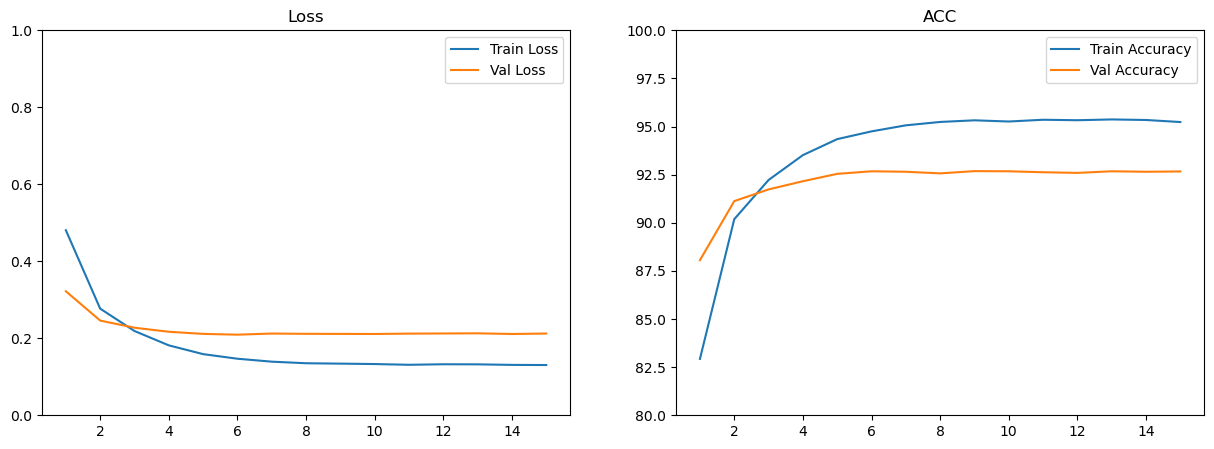

In [123]:
result_list = []
for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy}
  
    scheduler.step() # scheduler 업데이트!
    result_list.append(result)
    
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:

- 하이퍼 파라미터와 모델 구조
    - Batch_size: 64
    - 모델 구조: Conv2d(32) > Conv2d(64) > Conv2d(128) > FC(128) > FC(64) > FC(10)
        - 이미지이기 때문에 FC Layer만 사용하는 것보다 Convolution Layer를 적절히 활용하는 것이 더욱 좋습니다.
        - Convolution Layer 뒤에는 Maxpooling을 이용했습니다.
        - Maxpooling에서 **손실되는 노드가 없도록** 세 번째 Convolution Layer의 stride를 1에서 2로 변경하였습니다.

**1. Optimization**
- Optimizer로 **Adam** 이용
    - 대부분의 모델에는 이 Optimizer로 선정하므로 이를 따랐습니다.
- Learning Rate Scheduler로 **Exponential LR**을 사용
    - Learning Rate Scheduler를 사용하기 전에는 Error에 변동이 심했으나, 사용한 후에는 Error에 변동이 거의 없어서 안정적인 학습을 할 수 있었습니다.

**2. Regularization**
- **L2 Norm Regularizer** 이용
    - Optimizer의 인수에 weight_decay를 설정해줌으로써 L2 Norm Regularizer를 적용할 수 있습니다.
    - 1e-2, 1e-3으로 설정하니 성능이 오히려 나빠졌으며, 1e-4에서 좋은 결과를 보여서 1e-4로 설정했습니다.
- **Dropout** 적용
    - Dropout 50%(0.5)를 각각 FC Layer에 적용해보았으나, epoch 수가 15로 제한되어 있으므로 완전히 학습되기 전에 중단되는 현상이 발생했습니다.
    - 따라서 Dropout을 20%(0.2)로 조정해서 학습 속도를 빠르게 하였으며, 성능도 좋아졌습니다.

**3. Initialization**
- **He Initialization** 이용
    - 세 개의 FC Layer 중 앞의 두 FC Layer에 He Initialization을 적용했습니다.
    - 앞의 두 개에 He 초기화를 사용한 이유는 ReLU 활성화 함수를 사용했기 때문입니다.
    - 초기화는 성능을 미세하게 증가시켰습니다.

**4. Normalization**
- **Batch Normalization** 이용
    - 모든 Convolution Layer에 Batch Normalization을 적용했습니다.
    - Batch Normalization은 기존에 비해 1% 이상 성능을 향상시켰습니다.

- 최종적으로 모델의 Validaiton 정확도는 평균 **92.5%**를 달성할 수 있었습니다.
- 특히 Exponential LR을 사용했기 때문에, 모델의 실행 결과에 큰 편차가 없었습니다.